In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

plt.rcParams['font.size'] = 14

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Visualization of Augmentation Techniques
- In the cells below you can try to observe the effects of some of the augmentation techniques
- Please refer to this page for understanding the different augmentation techniques available: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Augmentation can be both Image Transformation based or Image Filtering based

<img src='https://miro.medium.com/max/1400/0*0Je9h2iT9m7ribFJ.png'>

In [15]:
datagen = ImageDataGenerator(brightness_range=[0.2,1.2],zoom_range=0.25)

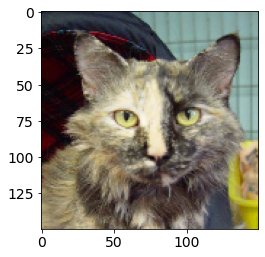

In [16]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/cats/cat.10.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

In [17]:
img = np.expand_dims(img,axis=0)

## Visualization of 15 Augmented Samples

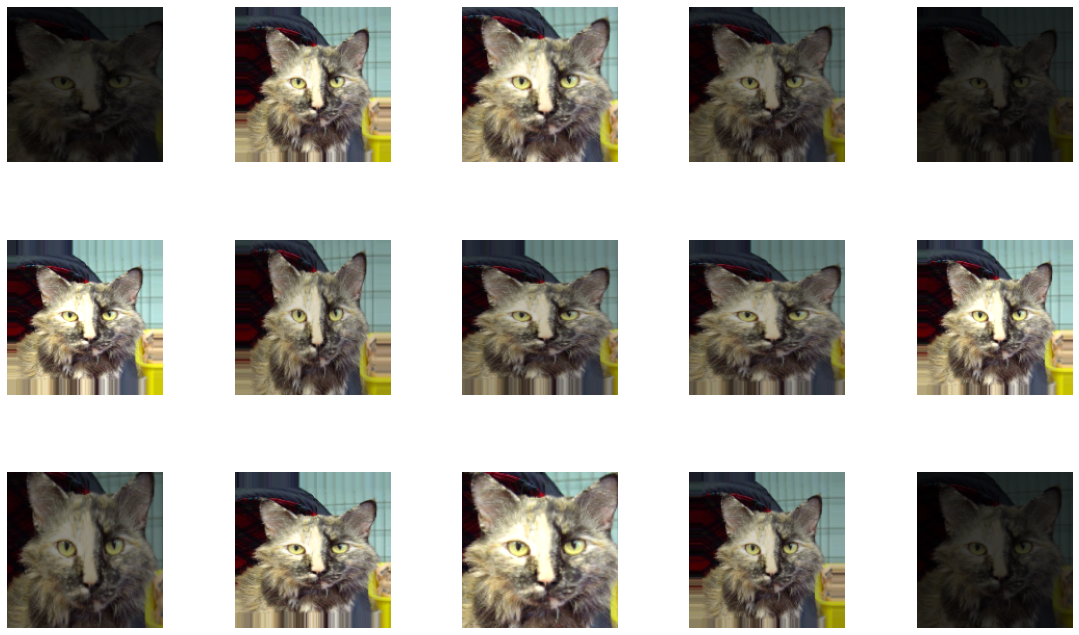

In [18]:
i = 0
plt.figure(figsize=(20,20))
for batch in datagen.flow(img, batch_size=1):
    i += 1
    plt.subplot(5 , 5,  i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.1)
    plt.imshow(batch[0]/255.)
    plt.axis('off')
    if i > 14:
        break

# ImageDataGenerator
- Generate batches of tensor image data with real-time data augmentation
- Set the batch size and image resolution size for the image data generator

<img src='https://miro.medium.com/max/1770/1*PNW2zbVxS5YnG1z9rUevnQ.png'>

In [9]:
img_size = 150
batch_size = 32


# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   brightness_range=[0.2,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../input/dogs-cats-images/dataset/training_set',  
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        '../input/dogs-cats-images/dataset/test_set',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Visulization of 15 Random Samples from a Batch of 32

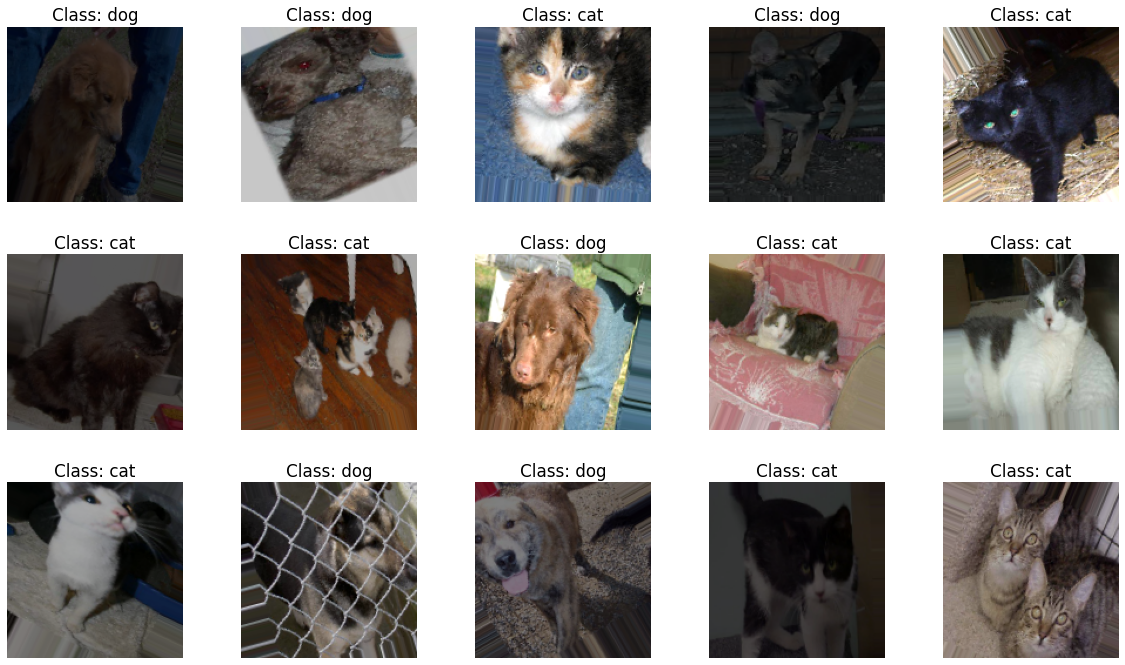

In [10]:
labels = ['cat','dog']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

# Model Definition

<h2>1. Sequential API</h2>
- Here we create the model layer-by-layer. It is very simple and easy to use. But sharing of layers or branching of layers is not allowed (We will see what sharing or branching means later). Also, you can’t have multiple inputs or outputs.
<h2>2. Functional API</h2>
- It is more flexible than the sequential API. It is more powerful than the sequential API in the sense branching or sharing of layers is allowed here. And also it can have multiple inputs and outputs.
<h2>3. Subclassing API</h2>
- You implement everything from scratch on your own. Use this if you have complex, out-of-the-box research use cases.
<br>
<img src='https://miro.medium.com/max/1200/1*WzwKtnA0LEhiCGdWTTpLaA.png'>

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, Flatten, Dense, Input

## Sequential API

In [27]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

## Functional API
- We will be using this for many advanced architectures in the future
- Since the model has been redefined using the functional api, the functional api model will considered for the rest of the code

In [28]:
input_layer = Input(shape=(150,150,3))
x = Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer,outputs=output_layer)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 128)       0   

In [30]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

# Model Callbacks
- Save the best converged model using checkpointing
- We will use EarlyStopping in later versions of the code, it is for stopping the training process if the loss does not converge for n subsequent epochs

<img src='https://miro.medium.com/max/973/1*nhmPdWSGh3ziatQKOmVq0Q.png'>

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [32]:
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

In [33]:
history = model.fit(train_generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

2023-02-05 17:29:58.808723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-05 17:30:00.494896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 132s 500ms/step - loss: 0.7033 - accuracy: 0.5282 - val_loss: 0.6804 - val_accuracy: 0.5560

Epoch 00001: val_loss improved from inf to 0.68044, saving model to model_cnn.h5
Epoch 2/20
250/250 [==============================] - 77s 308ms/step - loss: 0.6679 - accuracy: 0.5939 - val_loss: 0.6480 - val_accuracy: 0.6375

Epoch 00002: val_loss improved from 0.68044 to 0.64803, saving model to model_cnn.h5
Epoch 3/20
250/250 [==============================] - 73s 293ms/step - loss: 0.6498 - accuracy: 0.6279 - val_loss: 0.6042 - val_accuracy: 0.6770

Epoch 00003: val_loss improved from 0.64803 to 0.60419, saving model to model_cnn.h5
Epoch 4/20
250/250 [==============================] - 72s 288ms/step - loss: 0.6104 - accuracy: 0.6616 - val_loss: 0.5835 - val_accuracy: 0.6905

Epoch 00004: val_loss improved from 0.60419 to 0.58353, saving model to model_cnn.h5
Epoch 5/20
250/250 [==============================] - 73s 290ms/step - loss: 0.5731 - accu

# Learning Curves
- If the difference between the validation loss and training loss is too big then your model is overfitting

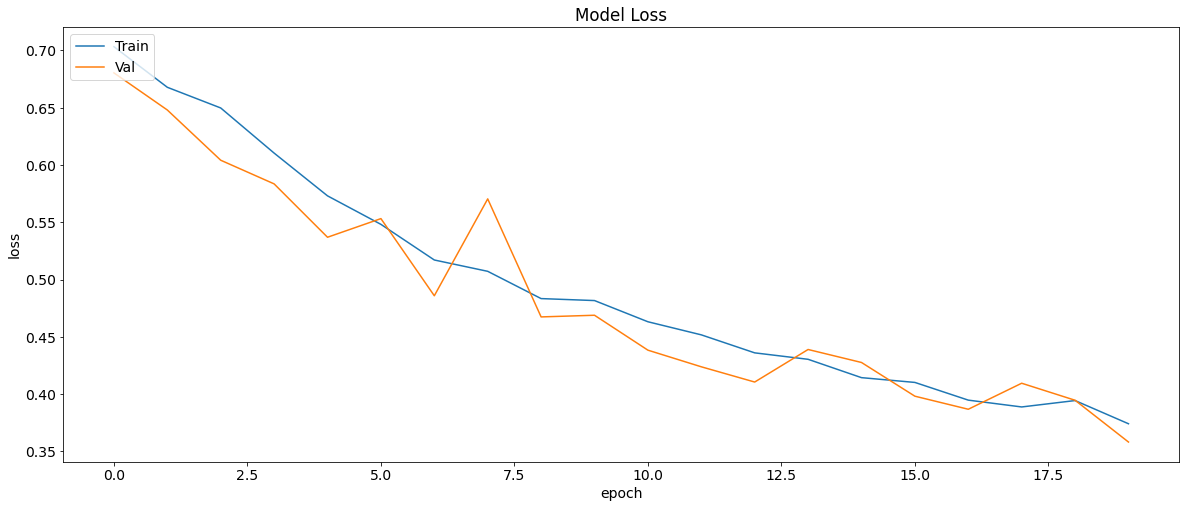

In [34]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

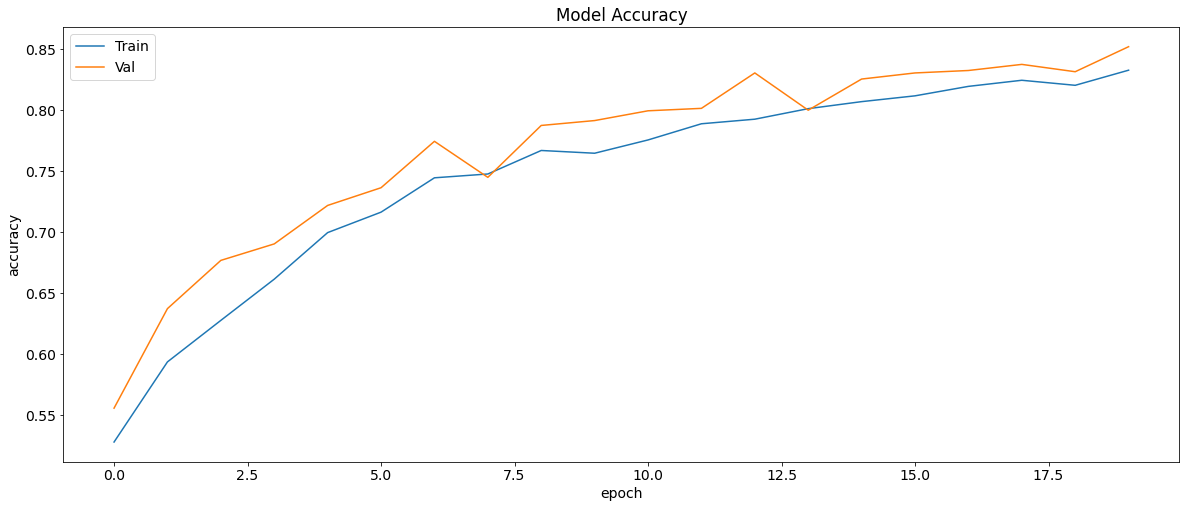

In [68]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [35]:
model = tf.keras.models.load_model('/kaggle/working/model_cnn.h5')

In [36]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_probs = y_pred.copy()

In [37]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

# Evaluation of Classification Model 

<img src='https://learnanalyticshere.files.wordpress.com/2021/02/image-1.png'>

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

## Classification Report

In [39]:
print(classification_report(y_test,y_pred,target_names = ['cats','dogs']))

              precision    recall  f1-score   support

        cats       0.88      0.81      0.85      1000
        dogs       0.82      0.89      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



## Confusion Matrix

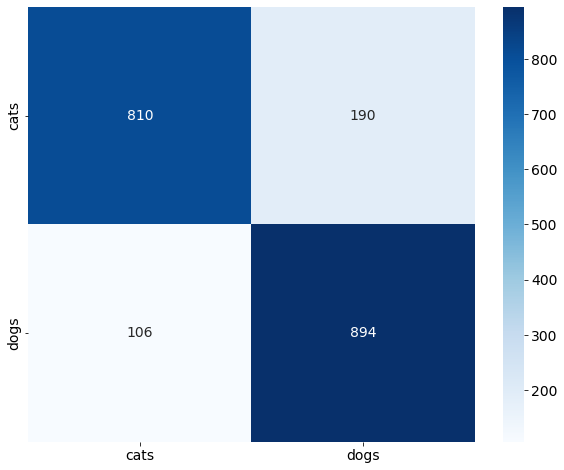

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['cats','dogs'],
            yticklabels=['cats','dogs'],cmap='Blues')
plt.show()

# Model Diagnosis
- Understanding the distribution of misclassification probabilities
- Visualizing the feature maps of each layer
- Visualizing the image embeddings (last but one layer's vector outputs) in 2D space using dimensionality reduction
    - PCA
    - t-SNE
    
<img src='https://miro.medium.com/max/1400/1*OuxhgVj1WDDfo5UO5GIhgA@2x.png'>

## Prediction Meta-Data
- Create a dataframe that stores the actual and predicted classes for the images as well as the prediction probabilities
- Since 0 is cat and 1 is dog, the higher the probability value the more confident the model is that the image is of a dog and the lower the probability the more confident the models is that the image is of a cat

In [42]:
filenames = validation_generator.filenames
data = pd.DataFrame()
data['filename'] = filenames
data['actual_class'] = y_test
data['predicted_class'] = y_pred
data['predicted_prob'] = y_pred_probs

In [43]:
misclassification = data[data['actual_class']!=data['predicted_class']]

## IQR and Histogram Analysis of Cats misclassified as Dogs

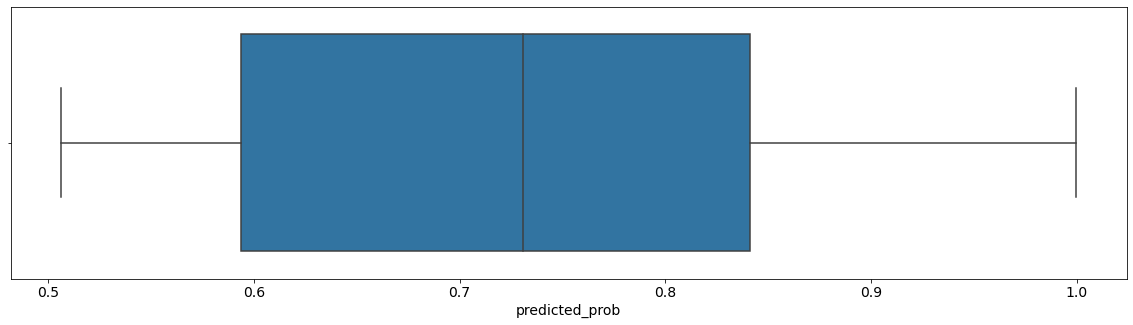

In [44]:
plt.figure(figsize=(20,5))
sns.boxplot(x=misclassification[misclassification['actual_class']==0]['predicted_prob'])
plt.show()

## Histogram Inference
- Here you can see that most of the misclassification lie in the 0.5-0.6 bin, i.e. the borderline of our probability threshold
- However it is a curious case that some misclassifications have probability > 0.8

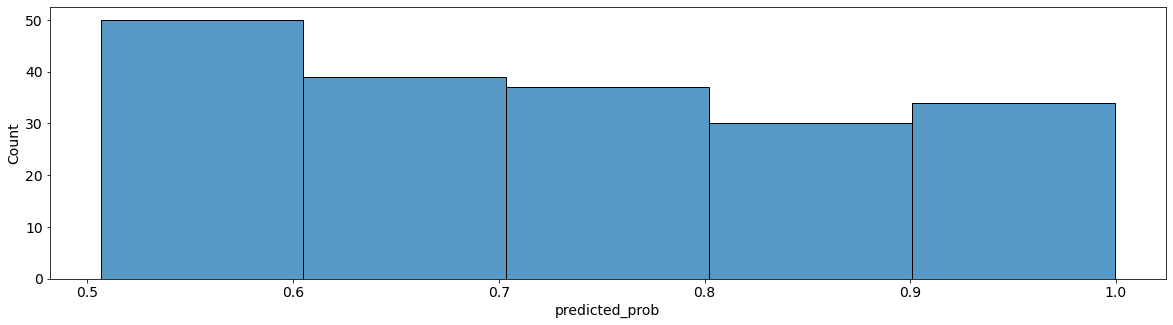

In [45]:
plt.figure(figsize=(20,5))
sns.histplot(misclassification[misclassification['actual_class']==0]['predicted_prob'],bins=5)
plt.show()

## Visualization of Misclassification Samples

In [46]:
misclassification[(misclassification['actual_class']==0) & (misclassification['predicted_prob']>0.9)]

,filename,actual_class,predicted_class,predicted_prob
0,cats/cat.4001.jpg,0,1.0,0.920378
52,cats/cat.4053.jpg,0,1.0,0.940971
84,cats/cat.4085.jpg,0,1.0,0.999099
118,cats/cat.4119.jpg,0,1.0,0.993626
150,cats/cat.4151.jpg,0,1.0,0.983780
173,cats/cat.4174.jpg,0,1.0,0.988191
189,cats/cat.4190.jpg,0,1.0,0.952870
197,cats/cat.4198.jpg,0,1.0,0.912341
210,cats/cat.4211.jpg,0,1.0,0.983369
219,cats/cat.4220.jpg,0,1.0,0.924418


## Visualization of High Confidence Misclassifications
- Its due to either being an incorrectly labelled image 
- Due to it being a clipart image where the prominent features of cat are not quite visible
- Positon of a cat in an image where its snout appears to be dog like due to its side ways appearance
- Whiskers which are more prominent features of cats are maybe not visible in some of the images

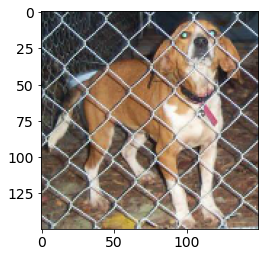

In [69]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4085.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

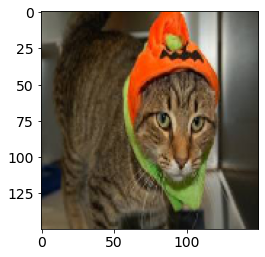

In [70]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4119.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

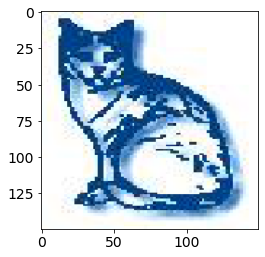

In [72]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4833.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

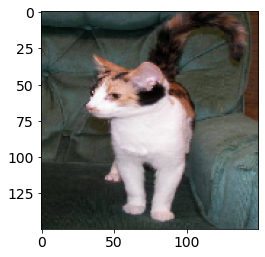

In [73]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4827.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

## Feature Map Visualization
- Visualization of the outputs of the intermediate layers

In [48]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4144.jpg',target_size=(150,150))
img = img_to_array(img)/255.

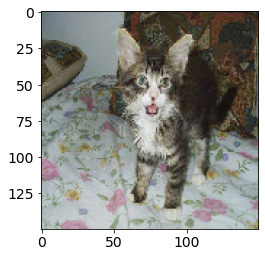

In [49]:
plt.imshow(img)

### We add an additional dimension even when we have to predict the class of one image

In [50]:
img = np.expand_dims(img,axis=0)
img.shape

(1, 150, 150, 3)

### Pick a layer by indexing the layers list
- Plug the index value of that layer to generate its output for a particular image

In [74]:
model.layers

In [54]:
layer_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = layer_model.predict(img)

In [55]:
feature_maps.shape

(1, 150, 150, 32)

### 15 Feature Map Samples from First Conv2D Layer
- Feel free to experiment around with different layer values
- You can see the different types of filter outputs for the first 15 filters of the first Conv2D layer

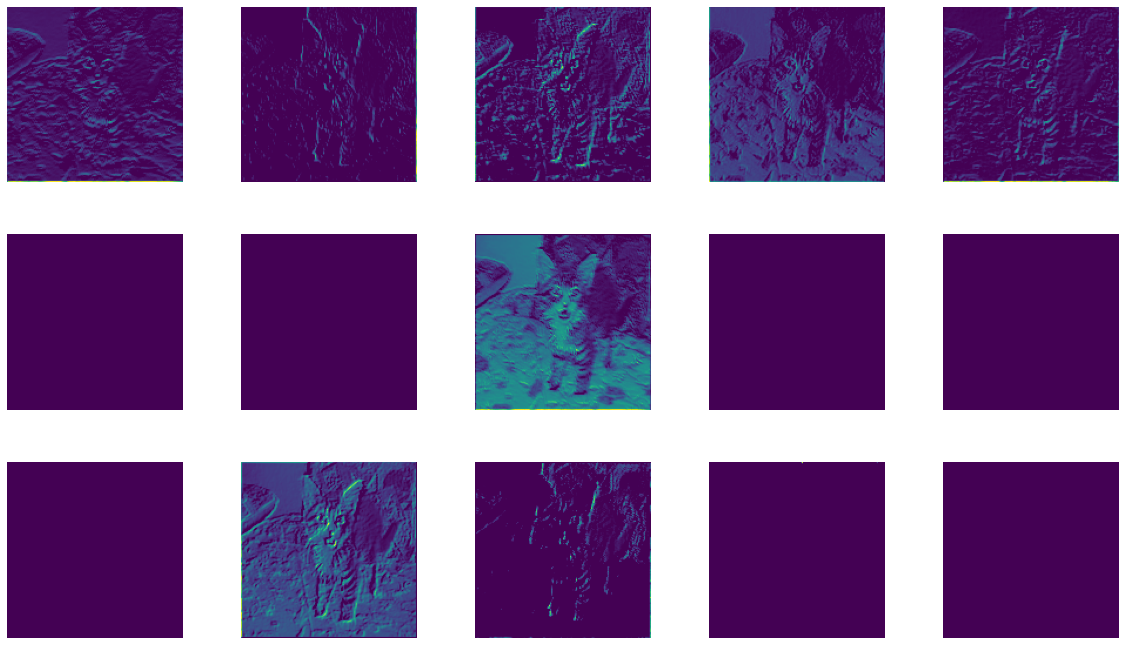

In [75]:
plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(feature_maps[0,:,:,i])
    plt.axis('off')

## Image Embeddings Visualization
- Use the output of the last but one layer i.e. the layer before the output layer. The vector output is known as **Embeddings**
- Shape of the embeddings will be No. of images x Hidden Layer units
- Apply PCA/t-SNE on the feature output and reduce it 2D
- **Note**: 2 components may not capture the required amount of variance explanation. This is only to be able to visualize the image embeddings in 2D

In [76]:
feature_extractor = Model(model.inputs,model.layers[-2].output)

In [77]:
features = feature_extractor.predict(validation_generator)

In [90]:
features.shape

(2000, 512)

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [79]:
pca = PCA(2)
pc_features = pca.fit_transform(features)

In [80]:
pc_features

array([[ -4.9728026 ,   3.6469707 ],
       [ -0.29655868,  -4.393524  ],
       [  5.8711643 ,  -3.2244475 ],
       ...,
       [  3.9743266 ,   2.3270147 ],
       [  1.9910495 ,  -3.5830066 ],
       [-11.712636  ,   3.9604557 ]], dtype=float32)

In [81]:
data[['PC1','PC2']] = pc_features

In [82]:
data

,filename,actual_class,predicted_class,predicted_prob,PC1,PC2
0,cats/cat.4001.jpg,0,1.0,0.920378,-4.972803,3.646971
1,cats/cat.4002.jpg,0,1.0,0.637764,-0.296559,-4.393524
2,cats/cat.4003.jpg,0,0.0,0.026213,5.871164,-3.224447
3,cats/cat.4004.jpg,0,0.0,0.026731,5.619200,-3.993791
4,cats/cat.4005.jpg,0,0.0,0.006477,10.296288,2.232977
...,...,...,...,...,...,...
1995,dogs/dog.4996.jpg,1,1.0,0.998819,-9.855183,1.489032
1996,dogs/dog.4997.jpg,1,1.0,0.994807,-5.617193,2.028945
1997,dogs/dog.4998.jpg,1,0.0,0.040229,3.974327,2.327015
1998,dogs/dog.4999.jpg,1,0.0,0.189860,1.991050,-3.583007


In [83]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

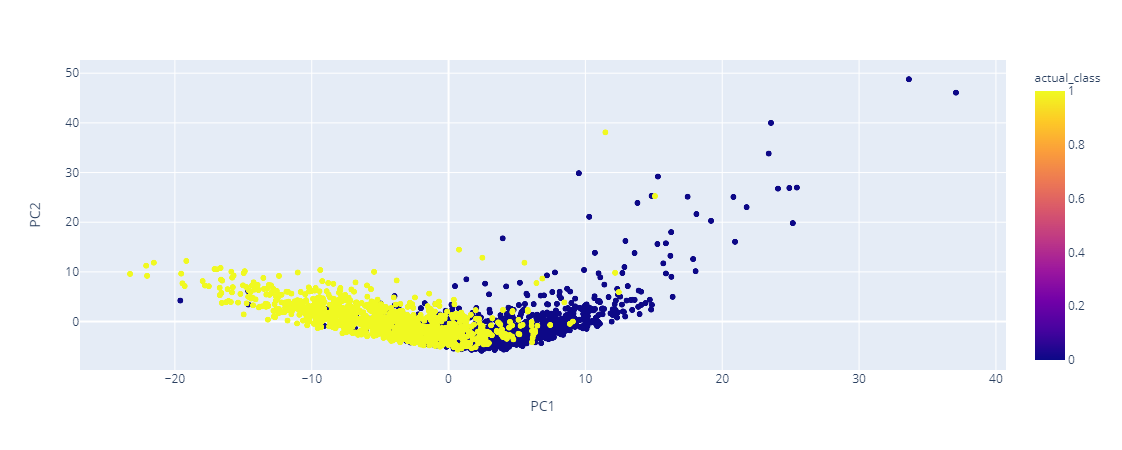

In [84]:
fig = px.scatter(data, x="PC1", y="PC2", color="actual_class", hover_data=['filename'])
fig.show()

In [92]:
X_embedded = TSNE(n_components=2).fit_transform(features)

In [93]:
X_embedded

array([[ 24.734087 ,   3.7027035],
       [ -8.429167 , -11.381029 ],
       [-42.26029  ,  -5.2035522],
       ...,
       [ -2.5933259,   8.190667 ],
       [-20.959114 ,  -1.671553 ],
       [ 60.380318 , -17.041584 ]], dtype=float32)

In [94]:
data[['Axis1','Axis2']] = X_embedded

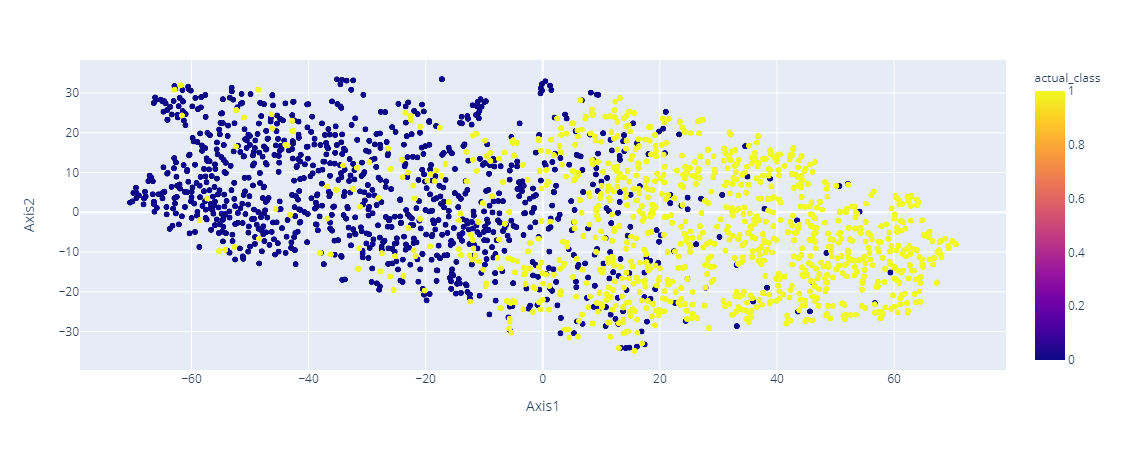

In [95]:
fig = px.scatter(data, x="Axis1", y="Axis2", color="actual_class", hover_data=['filename'])
fig.show()

## How to use above plots ?
- Try to observe the images whose embeddings are appearing closer they must be having some similar kind of features
- Refer to the misclassifications table to understand why exactly did an image get misclassified